In [1]:
dir = dirname(pwd()) * "/PROJECT"
include(dir * "/functions/Preamble.jl")
dir = dirname(pwd()) * "/PROJECT"

t0 = now()

  Activating project at `C:\Users\conno\Documents\CAMBRIDGE\Part III\Comp Project\JULIA\PROJECT`

Num threads: 4

2023-05-14T12:39:02.327

In [2]:
include(dir * "/functions/DataStructure.jl")
include(dir * "/functions/Bases.jl")
include(dir * "/functions/Plotting.jl")
include(dir * "/functions/Statistics.jl")
include(dir * "/functions/Simulation.jl")
include(dir * "/functions/SingleVertexApproxns.jl")

include(dir * "/functions/simulationFunctions/GroundStates.jl")

## Setup

In [3]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 20
rcParams["font.family"] = "Times New Roman"
PyPlot.matplotlib[:rc]("mathtext",fontset="stix")
PyPlot.matplotlib[:rc]("font",family="STIXGeneral",style="normal",size=18)

font = "Times New Roman"
fontsize = 20

20

## Demon

In [4]:
filefun = (method) ->  dir * "/data/" * method * ".jld";

method = "MicroDiff"
file = filefun(method);

In [5]:
load(file)

Dict{String, Any} with 20 entries:
  "Temperature"        => Any[]
  "NumFlippedEdges"    => [1.0]
  "twoFlip"            => false
  "C"                  => [0.0977938; 0.000742946;;;]
  "alpha"              => [0.760341; 0.00897289;;;]
  "VACF"               => [2.509; -0.2002; … ; 0.5; 1.0;;;]
  "num_histories"      => 1
  "D"                  => [0.878631; 0.0332865;;;]
  "basis"              => (Cell[Cell(false, 0.0, [0.0, 0.0], UInt32[], UInt32[0…
  "tau"                => 2:100
  "Size"               => [32, 32]
  "EnergyQuantisation" => 8
  "runtime"            => 1000
  "Dself"              => 0.583333
  "gamma"              => [-1.12677; 0.06078;;;]
  "Fields"             => [0.0]
  "MSD"                => [0.0; 2.509; … ; 361.75; 343.0;;;]
  "lambda"             => 0.0
  "therm_runtime"      => 109
  "xi"                 => 1.0

In [6]:
λ = load(file, "lambda")
ξ = load(file, "xi")
twoFlip = load(file, "twoFlip")
isSpinIce = (λ==0 && ξ==1)
δE = (λ==0) ? 8*ξ : 4*λ

8.0

In [7]:
z = Coordination(load(file, "basis"))
Dself = load(file, "Dself")

0.5833333333333334

In [8]:
if twoFlip
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z)) .* (1 .- Magnetisation(T, h, z)) ./ 2 # additional magnetisation factor for +-+- bond percolation
else
    Kfun = (T, h) -> Dself ./ 2 .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z))
end

Cfun = (T, h) -> 2/z .* (λ^2 .* sech.(λ ./T).^2 + 2 * h^2 .* sech.(h ./T).^2) ./ T.^2

if twoFlip
    Dfun = (T, h) -> Kfun(T, h) ./ Cfun(T, h)
else
    Dfun = (T, h) -> Kfun(T, h) ./ HeatCapacity(T, h, z)
end

#69 (generic function with 1 method)

In [9]:
𝒽 = load(file, "Fields");
colors = jetmap(length(𝒽));

In [10]:
if method == "DemonKubo" 
    Tobs = load(file, "ObservedTemperature");
    TobsStd = load(file, "ObservedTemperatureStd");
    T = load(file, "TargetTemperature");

    figure()
    for i in eachindex(𝒽)
        plotWithError(Tobs[:,i], T, colors[i], ".", TobsStd[:,i])
    end
    xlim([0,10.1])
    ylim([0,10.1])
    savefig("figs/Demon_Kubo_Temperature.png")
    # Just to check that out temperature estimates aren't too far off
else
    Tobs = load(file, "Temperature");
    Tobs = reshape(Tobs, size(Tobs)..., 1)
    TobsStd = zeros(size(Tobs));
end;

# Comparing two methods

In [99]:
file = filefun("DemonKubo")

λ = load(file, "lambda")
ξ = load(file, "xi")
twoFlip = load(file, "twoFlip")
isSpinIce = (λ==0 && ξ==1)
δE = (λ==0) ? 8*ξ : 4*λ

z = Coordination(load(file, "basis"))
Dself = load(file, "Dself")

0.5833333333333334

In [105]:
Variable = "Diffusivity"

Tobs = load(file, "ObservedTemperature");
TobsStd = load(file, "ObservedTemperatureStd");
Texp = load(file, "TargetTemperature");
T = load(filefun("MicroKubo"), "Temperature");

D_D = load(file, Variable);
DStd_D = load(file, Variable*"Std");

D_M = load(filefun("MicroKubo"), Variable);
DStd_M = load(filefun("MicroKubo"), Variable*"Std");


𝒽 = load(filefun("MicroKubo"), "Fields");
colors = jetmap(length(𝒽));

In [106]:
Cfun = (T, h) -> HeatCapacity(T, h, z)

Kfun = (T, h) -> 2/z * Dself .* (0.5 .* δE ./ T).^2 .* ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z))

Dfun = (T, h) ->  Kfun(T,h) ./ Cfun(T,h)

#246 (generic function with 1 method)

In [107]:
f_λ = 1
f_h = 1/4

A_λ = (T, h) -> ExcitationDensity(T, h, z) .* (1 .- AllExcitationDensity(T, h, z))
A_h = (T, h) -> Magnetisation(T, h, z) .* (1 .- Magnetisation(T, h, z))

aQ = (T, h) -> 1/2

#Cfun = (T, h) -> 2/z * ((λ ./ T).^2 .* sech.(λ ./T).^2 + 2 * (h ./ T).^2 .* sech.(h ./ T).^2)
#Kfun = (T, h) -> 2/z .* (f_λ .* A_λ(T,h) .* (2 .* λ ./ T).^2 + f_h .* A_h(T,h) .* (2 .* h ./ T).^2) .* aQ(T, h)

#252 (generic function with 1 method)

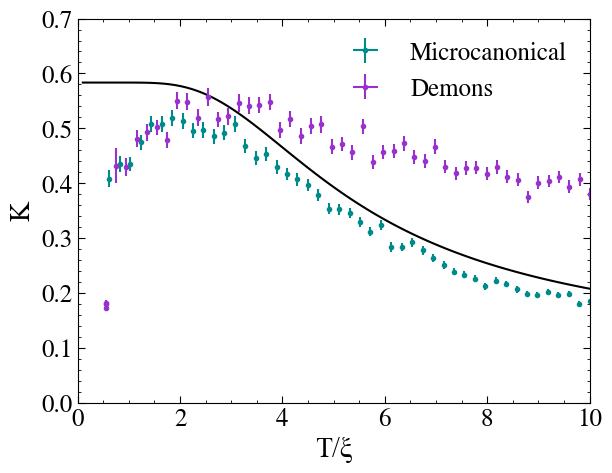

In [109]:
idx_D = 1:size(Tobs, 1)
idx_M = 1:length(T)

Xrange = [0,10]
Yrange = [0,0.7]
Tfit = range(Xrange[1], Xrange[2], length=100)

f = figure()
for i in eachindex(𝒽)
    plot(Tfit, Dfun(Tfit, 𝒽[i]), color=:black)
    
    plotWithError(D_M[1,1,idx_M,i], T[idx_M], :darkcyan, ".", "Microcanonical" , DStd_M[1,1,idx_M,i])
    plotWithError(D_D[idx_D,i], Tobs[idx_D,i], :darkorchid, ".", "Demons", DStd_D[idx_D,i], TobsStd[idx_D,i])
end

xlim(Xrange)
ylim(Yrange)

xlabel("T/ξ", fontname=font, fontsize=fontsize) # λ
ylabel("K", fontname=font, fontsize=fontsize)

ax = gca()
ax.tick_params(which="both", length=5, top="on", right="on", direction="in")
ax.tick_params(which="major", length=5)
ax.tick_params(which="minor", length=2)
minorticks_on()

f.subplots_adjust(bottom=0.15, left=0.15, right=0.95, top=0.95)

legend(frameon=false)

savefig("figs/" * Variable * ".pdf")

In [61]:
print(2 / log(prod(load(file, "Size"))))

0.25562221863533147

## Diffn in Field

In [126]:
Variable = "Diffusivity"

α = load(filefun("MicroDiff"), "alpha");
γ = load(filefun("MicroDiff"), "gamma");
T = load(filefun("MicroDiff"), "Temperature");

𝒽 = load(filefun("MicroDiff"), "Fields");
colors = jetmap(length(𝒽));

In [127]:
idx = 3:length(T)

3:20

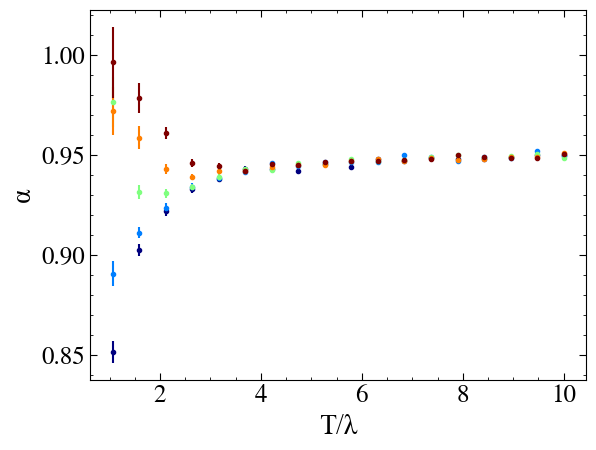

In [128]:
f = figure()
for i in eachindex(𝒽)
    plotWithError(α[1,idx,i], T[idx], colors[i], ".", "" , α[2,idx,i])
end

ax = gca()
ax.tick_params(which="both", length=5, top="on", right="on", direction="in")
ax.tick_params(which="major", length=5)
ax.tick_params(which="minor", length=2)
minorticks_on()

xlabel("T/λ", fontname=font, fontsize=fontsize)
ylabel("α", fontname=font, fontsize=fontsize)

savefig("figs/alpha_field.pdf")

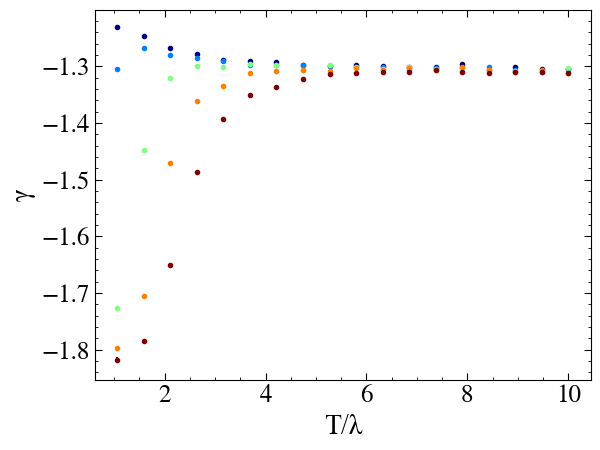

In [130]:
f = figure()
for i in eachindex(𝒽)
    plotWithError(γ[1,idx,i], T[idx], colors[i], ".", "" , γ[2,idx,i])
end

ax = gca()
ax.tick_params(which="both", length=5, top="on", right="on", direction="in")
ax.tick_params(which="major", length=5)
ax.tick_params(which="minor", length=2)
minorticks_on()

xlabel("T/λ", fontname=font, fontsize=fontsize)
ylabel("γ", fontname=font, fontsize=fontsize)

savefig("figs/gamma_field.pdf")

## Diffn Comparison

In [21]:
tau = 1:100

1:100

In [22]:
Variable = "MSD"

MSD_sqrIce = load(filefun("TMP/MicroDiff_sqrIce"), "MSD");
MSD_sqrTrc = load(filefun("TMP/MicroDiff_sqrTrc"), "MSD");
MSD_hexIce = load(filefun("TMP/MicroDiff_hexIce"), "MSD");
MSD_hexTrc = load(filefun("TMP/MicroDiff_hexTrc"), "MSD");

In [23]:
msd_sqrIce = mean(MSD_sqrIce[:,:,1], dims=2);
msd_sqrTrc = mean(MSD_sqrTrc[:,:,1], dims=2);
msd_hexIce = mean(MSD_hexIce[:,:,1], dims=2);
msd_hexTrc = mean(MSD_hexTrc[:,:,1], dims=2);

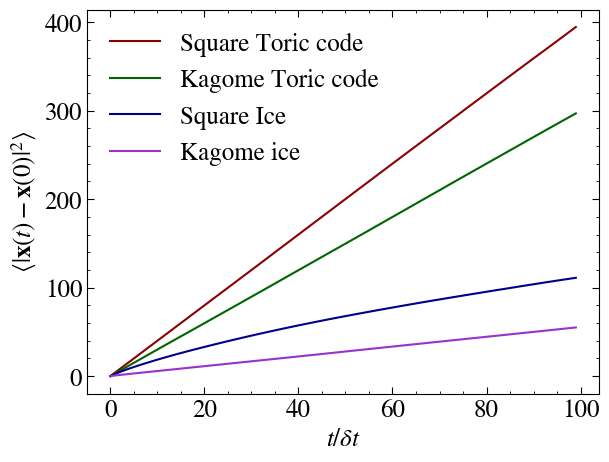

In [24]:
f = figure()
plot(msd_sqrTrc[tau], color=:darkred, label = "Square Toric code")
plot(msd_hexTrc[tau], color=:darkgreen, label = "Kagome Toric code")
plot(msd_sqrIce[tau], color=:darkblue, label = "Square Ice")
plot(msd_hexIce[tau], color=:darkorchid, label = "Kagome ice")

    
xlabel("\$t/\\delta t\$")
ylabel("\$\\langle|\\mathbf{x}(t)-\\mathbf{x}(0)|^2\\rangle\$")

ax = gca()
ax.tick_params(which="both", length=5, top="on", right="on", direction="in")
ax.tick_params(which="major", length=5)
ax.tick_params(which="minor", length=2)
minorticks_on()

legend(frameon=false)

f.subplots_adjust(bottom=0.15, left=0.15, right=0.95, top=0.95)

savefig("figs/" * Variable * ".pdf")

In [25]:
Variable = "VACF"

VACF_sqrIce = load(filefun("TMP/MicroDiff_sqrIce"), "VACF");
VACF_sqrTrc = load(filefun("TMP/MicroDiff_sqrTrc"), "VACF");
VACF_hexIce = load(filefun("TMP/MicroDiff_hexIce"), "VACF");
VACF_hexTrc = load(filefun("TMP/MicroDiff_hexTrc"), "VACF");

In [26]:
vacf_sqrIce = mean(VACF_sqrIce[:,:,1], dims=2);
vacf_sqrTrc = mean(VACF_sqrTrc[:,:,1], dims=2);
vacf_hexIce = mean(VACF_hexIce[:,:,1], dims=2);
vacf_hexTrc = mean(VACF_hexTrc[:,:,1], dims=2);

vacf_sqrIce[2:end] .*= sign(vacf_sqrIce[2]);
vacf_sqrTrc[2:end] .*= sign(vacf_sqrTrc[2]);
vacf_hexIce[2:end] .*= sign(vacf_hexIce[2]);
vacf_hexTrc[2:end] .*= sign(vacf_hexTrc[2]);

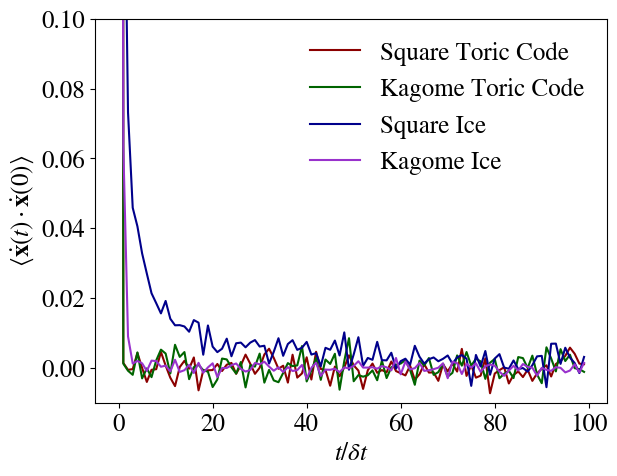

In [27]:
f = figure()
plot(vacf_sqrTrc[tau], color=:darkred, label = "Square Toric Code")
plot(vacf_hexTrc[tau], color=:darkgreen, label = "Kagome Toric Code")
plot(vacf_sqrIce[tau], color=:darkblue, label = "Square Ice")
plot(vacf_hexIce[tau], color=:darkorchid, label = "Kagome Ice")


ylim([-0.01,0.1])

xlabel("\$t/\\delta t\$")
ylabel("\$\\langle \\dot{\\mathbf{x}}(t) \\cdot \\dot{\\mathbf{x}}(0) \\rangle\$")

legend(frameon=false)

f.subplots_adjust(bottom=0.15, left=0.15, right=0.95, top=0.95)

savefig("figs/" * Variable * ".pdf")